## Importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library



print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Download the New York Dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    


In [4]:
neighborhoods_data = newyork_data['features']
#neighborhoods_data

## Defining columns and instantiating the dataframe 

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
nyc_neighborhoods = pd.DataFrame(columns=column_names)
nyc_neighborhoods

,Borough,Neighborhood,Latitude,Longitude


##  Transforming  the data into a padas dataframe 

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

## Showing the first 5 rows of the data

In [7]:
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Define Foursquare Credentials and Version

In [8]:
# The code was removed by Watson Studio for sharing.

## Function that will retrieve all the venues in each borough within a 500 meter radius.

In [9]:
def getNearbyVenues(boroughs,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for  borough,name, lat, lng in zip(boroughs,names, latitudes, longitudes):
        #print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng,                            
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],                         
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Boroughs',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
nyc_neighborhoods_venues = getNearbyVenues(boroughs=nyc_neighborhoods['Borough'],
                                    names=nyc_neighborhoods['Neighborhood'],
                                    latitudes=nyc_neighborhoods['Latitude'],
                                   longitudes=nyc_neighborhoods['Longitude']
                                  )


## Showing the first 5 records of the data.

In [45]:
nyc_neighborhoods_venues.head()

,Boroughs,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
4,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


## showing the shape of the data. Note, a total of 6,131 rows and 8 columns were returned. 

In [46]:
nyc_neighborhoods_venues.shape

(6131, 8)

## Renaming the 'Venue Category' column to 'Venue_Category'

In [47]:
nyc_restaurants =nyc_neighborhoods_venues.rename(columns={'Venue Category':'Venue_Category'},inplace=True)

## Selecting all venues that contains the word "Restaurant" and removing those that does not state the type of restaurant. Then showing the  first 5 rows of the data.

In [48]:
nyc_restaurants =nyc_neighborhoods_venues[nyc_neighborhoods_venues.Venue_Category.str.contains('Restaurant')].reset_index(drop=True)

# removing all restaurant category that does not specify the type of restaurant 
nyc_restaurants = nyc_restaurants[nyc_restaurants['Venue_Category'] != 'Restaurant'].reset_index(drop=True)
print(nyc_restaurants.shape)




(1392, 8)


In [49]:
nyc_restaurants.head()

,Boroughs,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,Arby's,40.870280,-73.828611,Fast Food Restaurant
2,Bronx,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant
3,Bronx,Co-op City,40.874294,-73.829939,Kennedy's,40.876807,-73.829627,Fast Food Restaurant
4,Bronx,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,Caribbean Restaurant


## Importing ploting library 

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

## Bar char showing count of restaurants in New yourk city

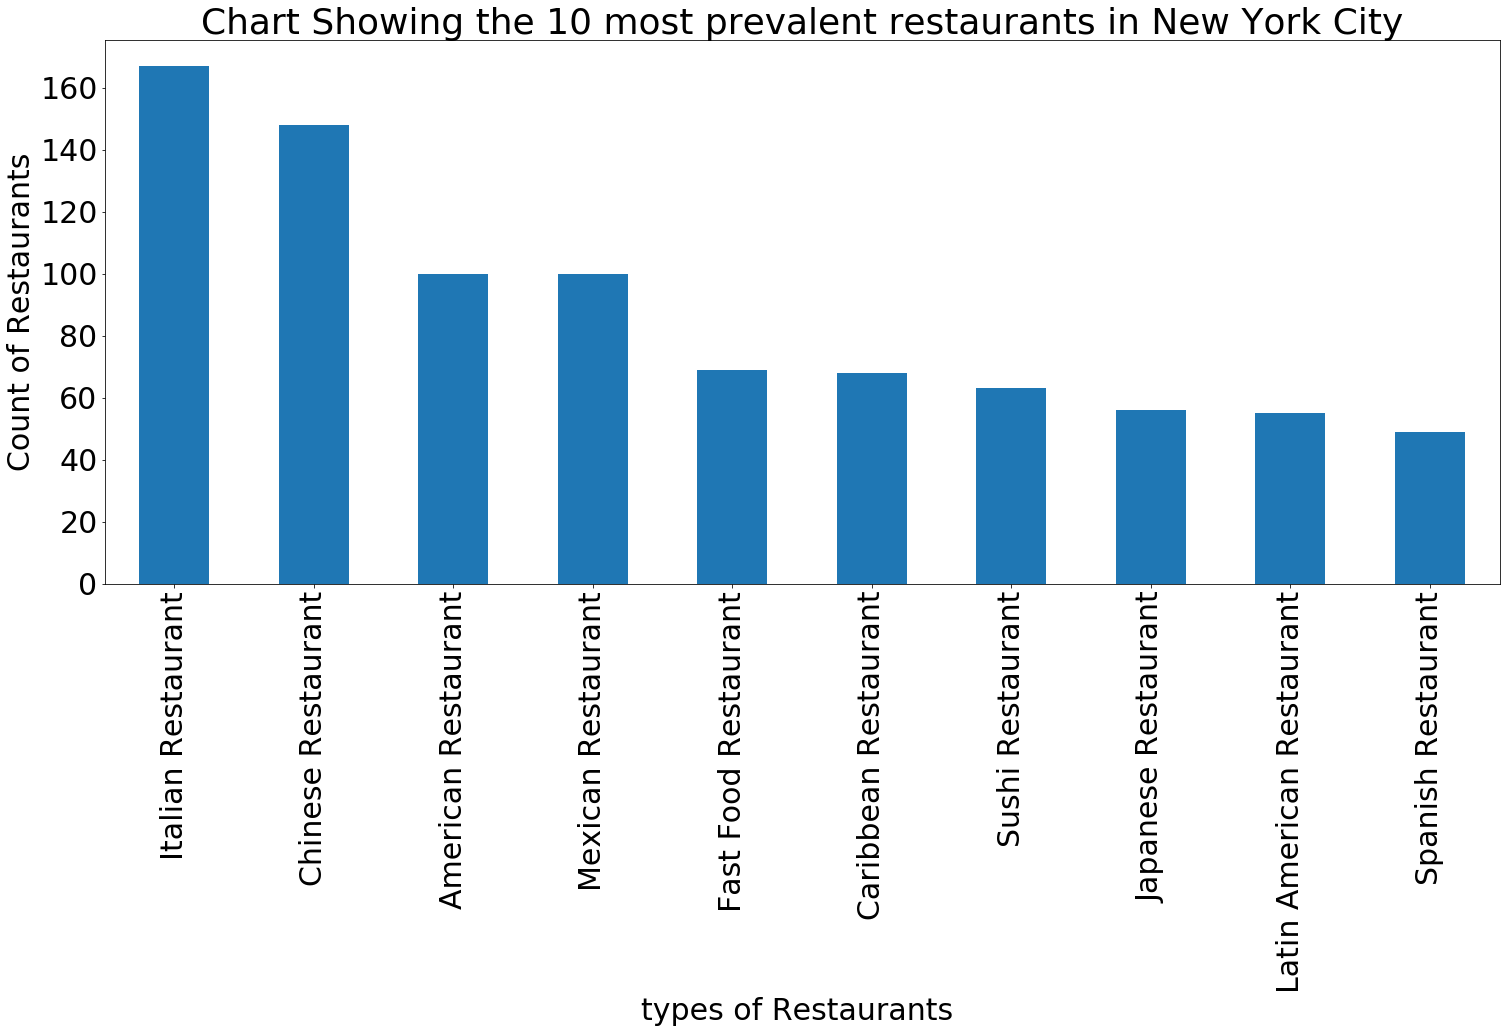

In [71]:
rescount=nyc_restaurants.groupby('Venue_Category').count()
rescount.sort_values("Boroughs",ascending=False,inplace=True)

rescount['Boroughs'].head(10).plot.bar(figsize=(25, 10))
plt.title('Chart Showing the 10 most prevalent restaurants in New York City')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})



## Showing the number of restaurants in each borough.

In [55]:
rescount=nyc_restaurants.groupby('Boroughs').count()
rescount=rescount.rename(columns={'Venue_Category':'Number of restaurants'})
rescount.sort_values("Number of restaurants",ascending=False,inplace=True)
rescount[['Number of restaurants']]

,Number of restaurants
Boroughs,
Queens,403
Brooklyn,340
Manhattan,304
Bronx,205
Staten Island,140


## Visualizing restaurants by boroughs

###  The Bronxs

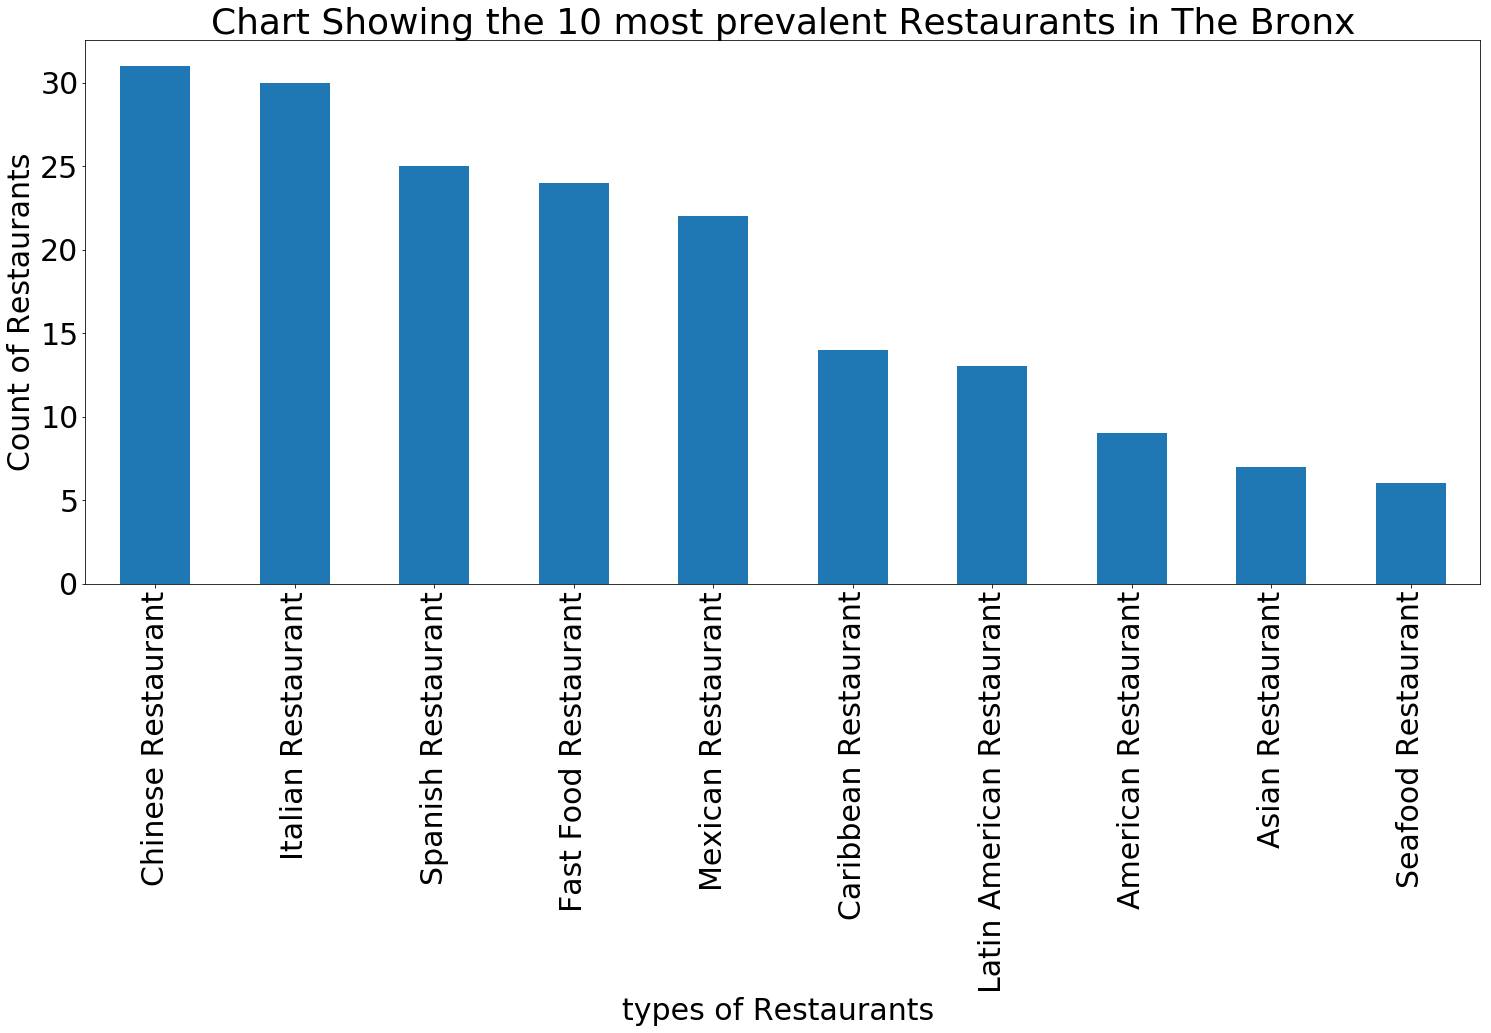

In [72]:
bronx_res = nyc_restaurants[nyc_restaurants['Boroughs'] == 'Bronx'].reset_index(drop=True)
bronx_res = bronx_res.groupby('Venue_Category').count()

bronx_res.sort_values("Boroughs",ascending=False,inplace=True)

bronx_res['Boroughs'].head(10).plot.bar(figsize=(25, 10))
plt.title('Chart Showing the 10 most prevalent Restaurants in The Bronx')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})



## table showing the 10 most prevalent restaurants and the number of locations in the Bronx

In [85]:
bronx_top_ten = bronx_res.rename(columns={'Boroughs':'Number of locations'}).head(10)

bronx_top_ten[['Number of locations']]



,Number of locations
Venue_Category,
Chinese Restaurant,31
Italian Restaurant,30
Spanish Restaurant,25
Fast Food Restaurant,24
Mexican Restaurant,22
Caribbean Restaurant,14
Latin American Restaurant,13
American Restaurant,9
Asian Restaurant,7


###  Manhattan

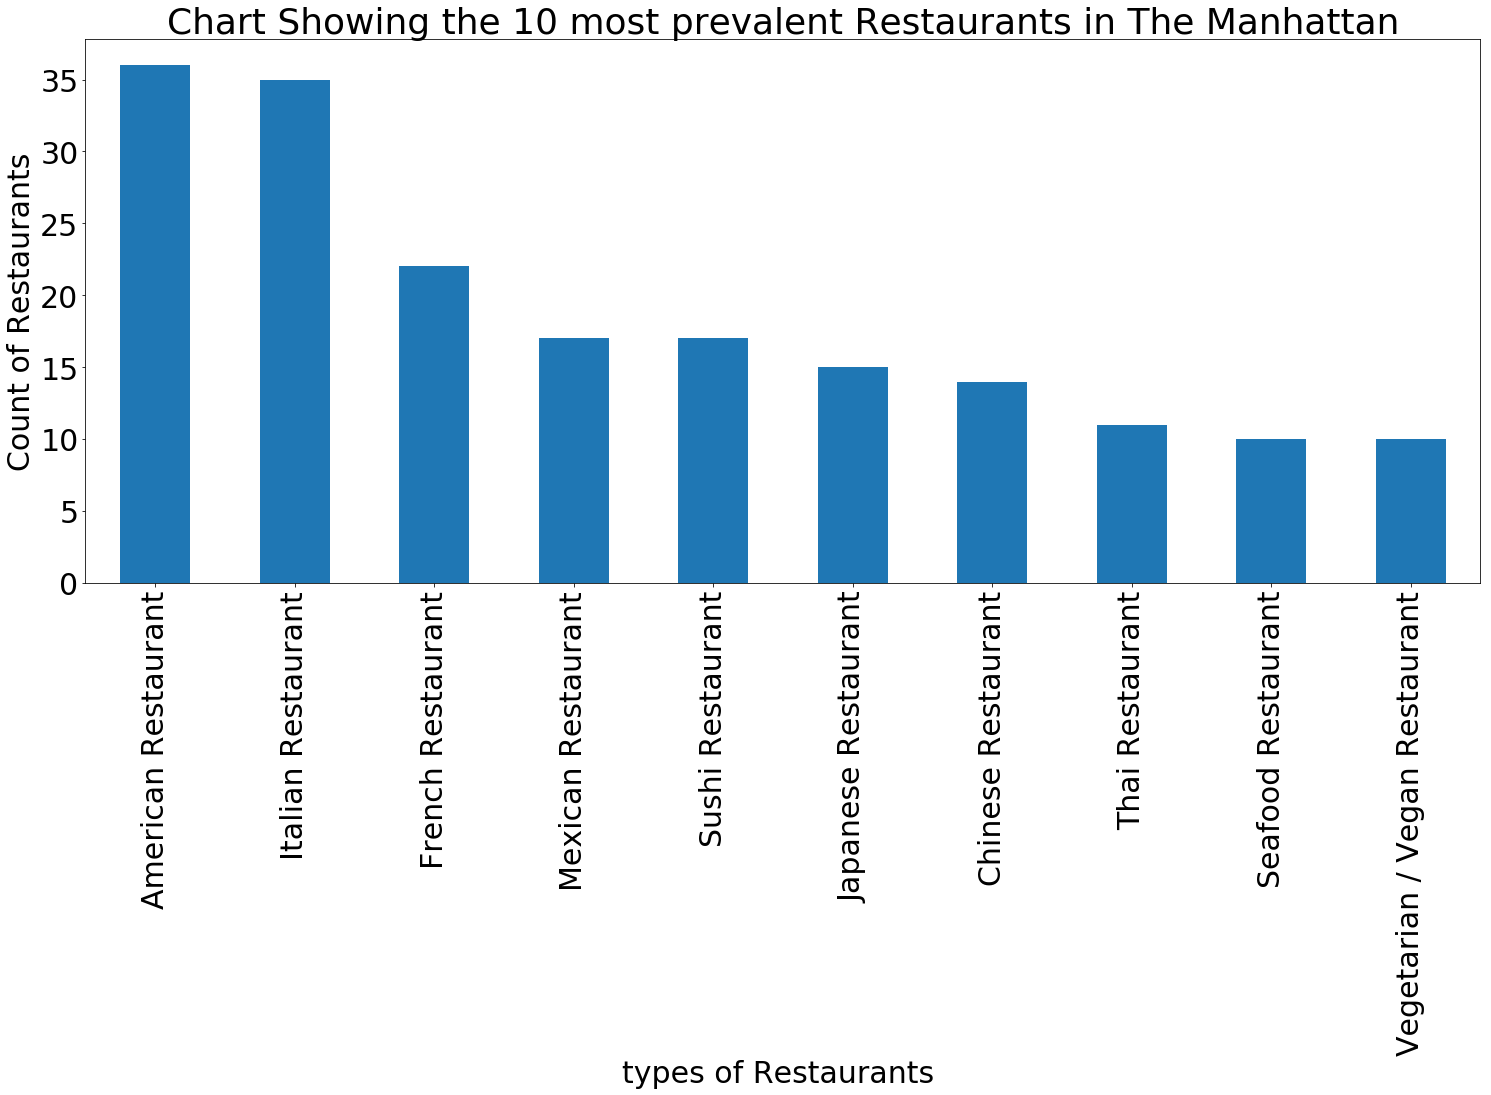

In [73]:
manhattan_res = nyc_restaurants[nyc_restaurants['Boroughs'] == 'Manhattan'].reset_index(drop=True)
manhattan_res = manhattan_res.groupby('Venue_Category').count()

manhattan_res.sort_values("Boroughs",ascending=False,inplace=True)

manhattan_res['Boroughs'].head(10).plot.bar(figsize=(25, 10))

plt.title('Chart Showing the 10 most prevalent Restaurants in The Manhattan')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})

## table showing the 10 most prevalent restaurants and the number of locations in Manhattan

In [84]:
manhattan_top_ten = manhattan_res.rename(columns={'Boroughs':'Number of locations'}).head(10)

manhattan_top_ten[['Number of locations']]


,Number of locations
Venue_Category,
American Restaurant,36
Italian Restaurant,35
French Restaurant,22
Mexican Restaurant,17
Sushi Restaurant,17
Japanese Restaurant,15
Chinese Restaurant,14
Thai Restaurant,11
Seafood Restaurant,10


### Brooklyn

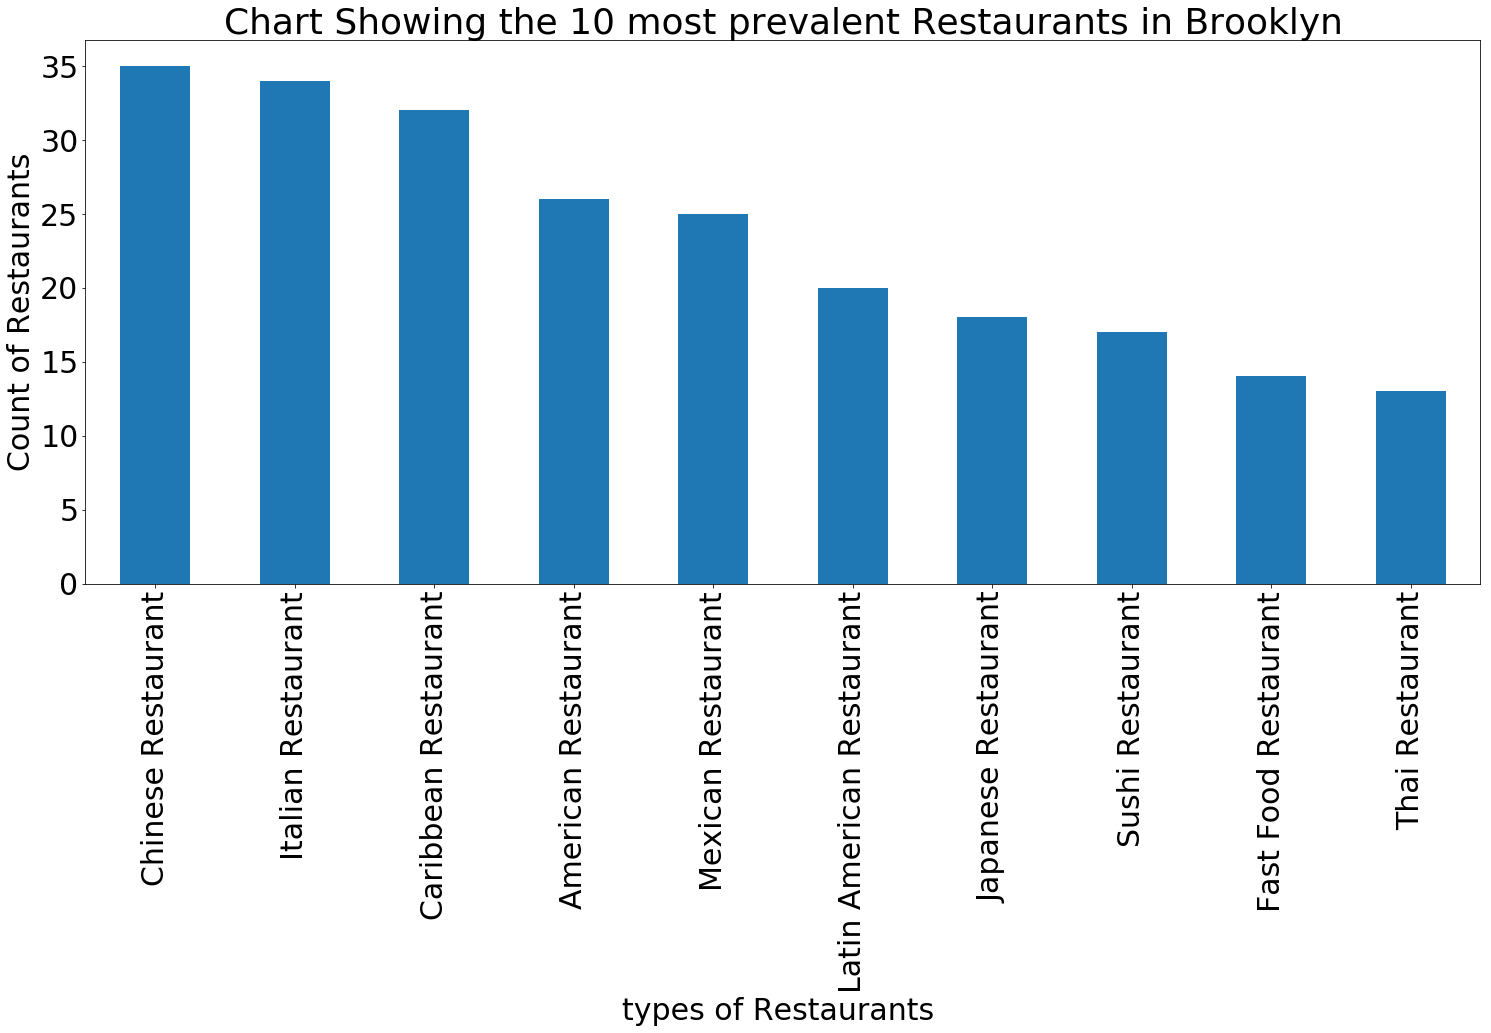

In [88]:
Brooklyn_res = nyc_restaurants[nyc_restaurants['Boroughs'] == 'Brooklyn'].reset_index(drop=True)
Brooklyn_res = Brooklyn_res.groupby('Venue_Category').count()

Brooklyn_res.sort_values("Boroughs",ascending=False,inplace=True)

Brooklyn_res['Boroughs'].head(10).plot.bar(figsize=(25, 10))

plt.title('Chart Showing the 10 most prevalent Restaurants in Brooklyn')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})

## table showing the 10 most prevalent restaurants and the number of locations  Brooklyn

In [82]:
brooklyn_top_ten = Brooklyn_res.rename(columns={'Boroughs':'Number of locations'}).head(10)

brooklyn_top_ten[['Number of locations']]


,Number of locations
Venue_Category,
Chinese Restaurant,35
Italian Restaurant,34
Caribbean Restaurant,32
American Restaurant,26
Mexican Restaurant,25
Latin American Restaurant,20
Japanese Restaurant,18
Sushi Restaurant,17
Fast Food Restaurant,14


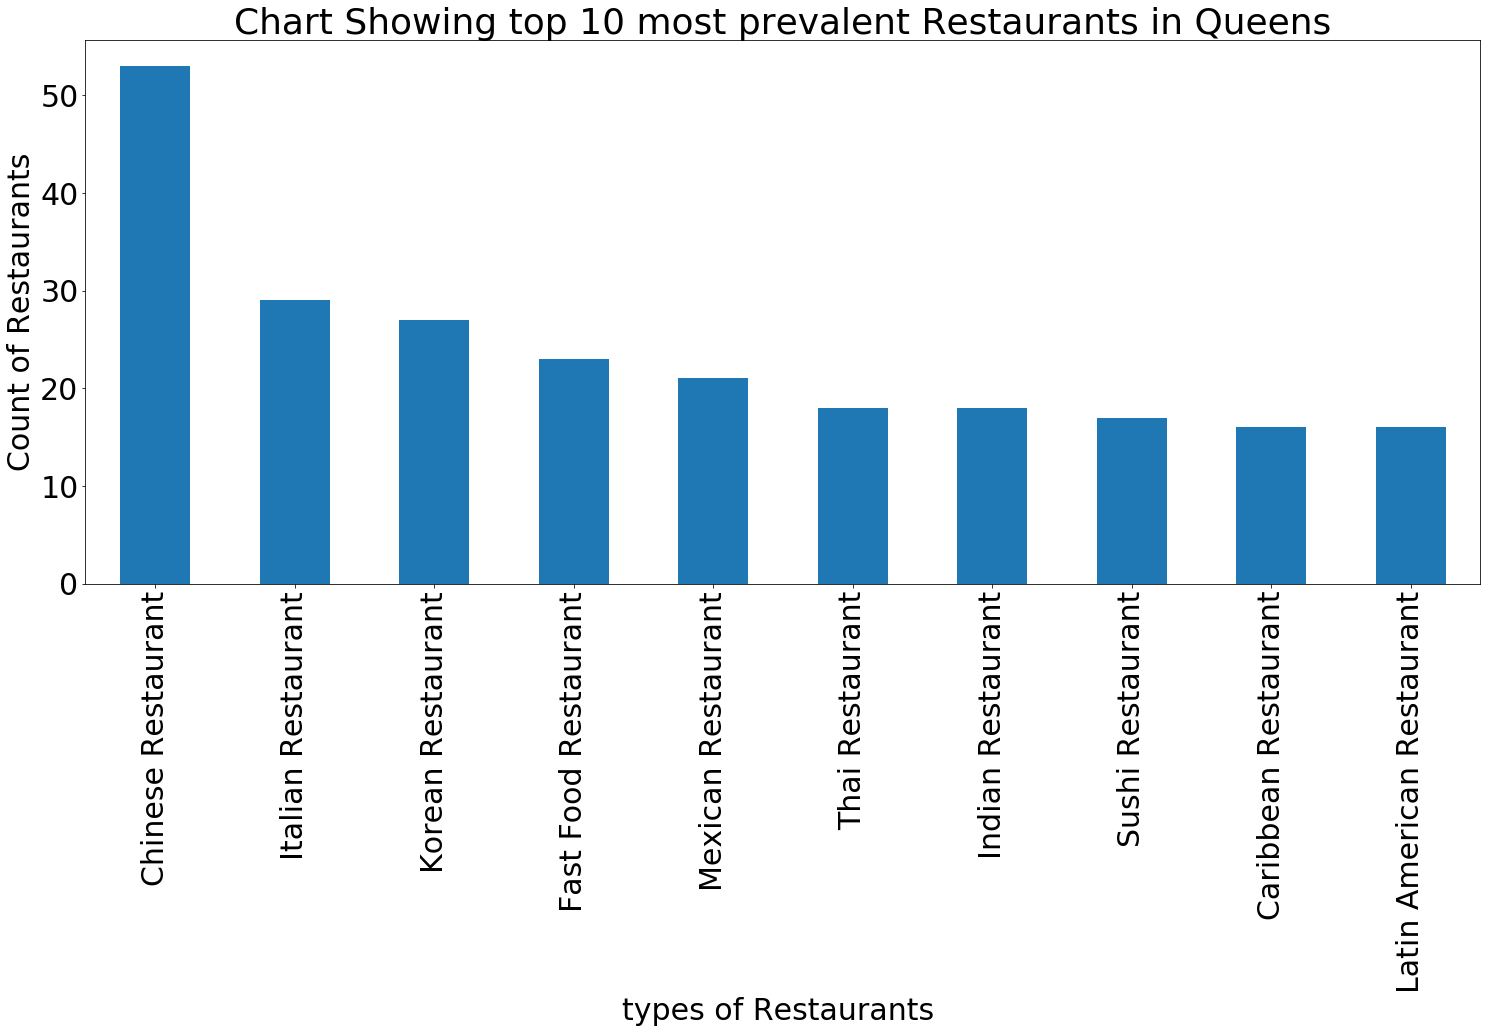

In [62]:
Queens_res = nyc_restaurants[nyc_restaurants['Boroughs'] == 'Queens'].reset_index(drop=True)
Queens_res = Queens_res.groupby('Venue_Category').count()

Queens_res.sort_values("Boroughs",ascending=False,inplace=True)

Queens_res['Boroughs'].head(10).plot.bar(figsize=(25, 10))
plt.title('Chart Showing top 10 most prevalent Restaurants in Queens')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})


In [86]:
queens_top_ten = Queens_res.rename(columns={'Boroughs':'Number of locations'}).head(10)

queens_top_ten[['Number of locations']]


,Number of locations
Venue_Category,
Chinese Restaurant,53
Italian Restaurant,29
Korean Restaurant,27
Fast Food Restaurant,23
Mexican Restaurant,21
Thai Restaurant,18
Indian Restaurant,18
Sushi Restaurant,17
Caribbean Restaurant,16


### Staten Island

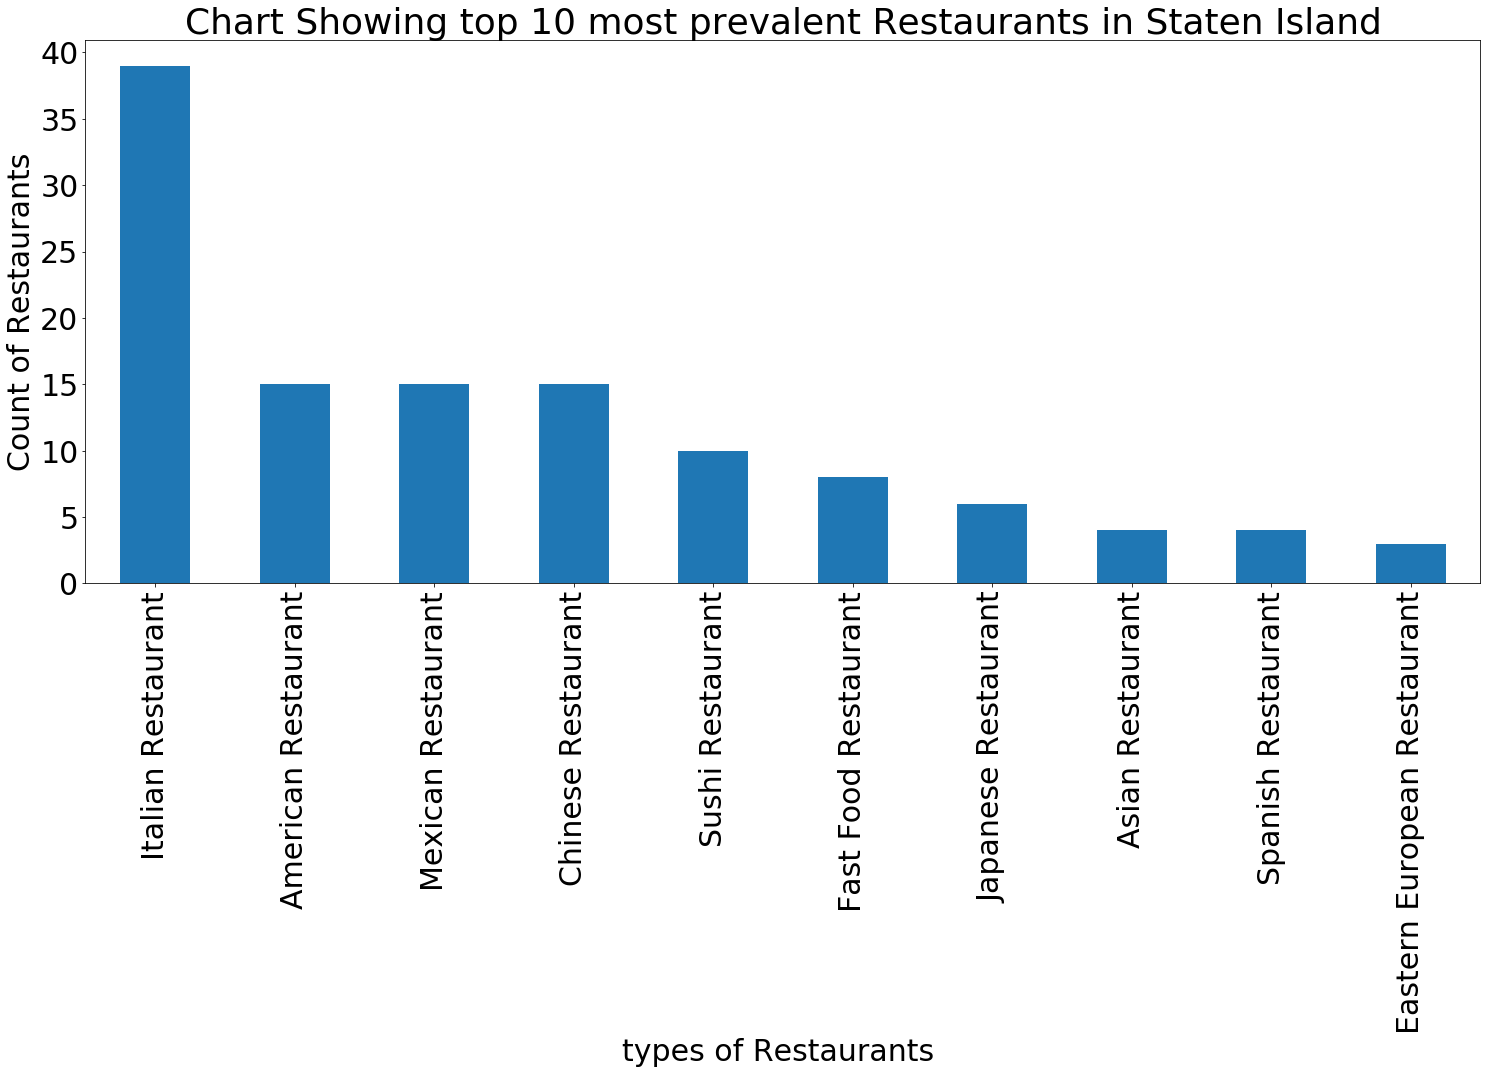

In [89]:
staten_isl_res = nyc_restaurants[nyc_restaurants['Boroughs'] == 'Staten Island'].reset_index(drop=True)
staten_isl_res = staten_isl_res.groupby('Venue_Category').count()

staten_isl_res.sort_values("Boroughs",ascending=False,inplace=True)

staten_isl_res['Boroughs'].head(10).plot.bar(figsize=(25, 10))
plt.title('Chart Showing top 10 most prevalent Restaurants in Staten Island')
plt.ylabel('Count of Restaurants')
plt.xlabel('types of Restaurants ')
plt.rcParams.update({'font.size': 30})

In [87]:
staten_top_ten = staten_isl_res.rename(columns={'Boroughs':'Number of locations'}).head(10)

staten_top_ten[['Number of locations']]


,Number of locations
Venue_Category,
Italian Restaurant,39
American Restaurant,15
Mexican Restaurant,15
Chinese Restaurant,15
Sushi Restaurant,10
Fast Food Restaurant,8
Japanese Restaurant,6
Asian Restaurant,4
Spanish Restaurant,4


## Selecting Caribbean Restaurants in New york City and showing the first 5 rows of the data.

In [66]:
nyc_caribbean_rest=nyc_neighborhoods_venues[nyc_neighborhoods_venues.Venue_Category.str.contains('Caribbean Restaurant')].reset_index(drop=True)

nyc_caribbean_rest.head()

,Boroughs,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,Bronx,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,Caribbean Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,Golden Krust Caribbean Restaurant,40.888488,-73.831083,Caribbean Restaurant
3,Bronx,Eastchester,40.887556,-73.827806,Royal Caribbean Bakery,40.888249,-73.831661,Caribbean Restaurant
4,Bronx,Kingsbridge,40.881687,-73.902818,El Malecon,40.879338,-73.904457,Caribbean Restaurant


## Showing the number of rows and column 

In [67]:
nyc_caribbean_rest.shape

(68, 8)

## Number of Caribbean Restaurants in New york City By borough.

In [102]:
rescount=nyc_caribbean_rest.groupby('Boroughs').count()

rescount=rescount.rename(columns={'Venue_Category':'Number of restaurants'})
rescount.sort_values('Number of restaurants',ascending=False,inplace=True)
rescount[['Number of restaurants']].head(5)





,Number of restaurants
Boroughs,
Brooklyn,32
Queens,16
Bronx,14
Manhattan,5
Staten Island,1


## Getting the lattitude and longitud values of New York City

In [69]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


## Map of New York City with location of Caribbean Restaurants superimposed on it.

In [70]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood ,venue in zip(nyc_caribbean_rest['Venue Latitude'], nyc_caribbean_rest['Venue Longitude'], nyc_caribbean_rest['Boroughs'], nyc_caribbean_rest['Neighborhood'],nyc_caribbean_rest['Venue']):
    label = 'Name of restaurant :,{}, Location: {} ,{}'.format(venue,neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork